# Basic ML Classifiers

In [1]:
import os
from os import path

import numpy as np
import cv2
from skimage import io, color, transform
import matplotlib.pyplot as plt

In [7]:
def resize_image(img, size, padding=255):
    '''
    Resize the given image to specified size
    Inputs:
        img = Image to be resized (Numpy NDArray)
        size = Scalar value. Image will be resized to (size, size)
    Returns:
        reszd_img = Resized image (Numpy NDArray)
    '''
    # Append zeros or ones based on the choice of padding
    # to maintain the aspect ratio of the image
    rows, cols = img.shape[:2]
    max_size = max(rows, cols)
    canvas = np.ones((max_size, max_size), np.uint8) * padding
    
    # Place the actual image at the center of the canvas
    c_x, c_y = max_size / 2, max_size / 2
    x_beg = max(0, c_x - (cols / 2))
    y_beg = max(0, c_y - (rows / 2))
    x_end, y_end = x_beg + cols, y_beg + rows
    canvas[y_beg: y_end, x_beg: x_end] = img
        
    # Resize the image and write to op_dir_path specified
    reszd_img = transform.resize(canvas, (size, size))
    reszd_img = np.asarray(reszd_img * 255, np.uint8)
    return reszd_img

In [2]:
def extract_features(image):
    '''
    Extract the features from the Image
    '''
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_img = resize_image(gray_img, 250)
    gray_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
    
    # Binarize the image using Adaptive thresholding
    th, bin_img = cv2.threshold(gray_img, 250, 255, cv2.THRESH_BINARY_INV)
    
    # Close the holes by Morphological operations (Erosion and Dilation)
    struct_elem = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    smooth_bin_img = cv2.erode(bin_img, struct_elem, iterations=1)
    smooth_bin_img = cv2.dilate(smooth_bin_img, struct_elem, iterations=2)
    
    # Find all the contours from the binary image
    img, contours, heirarchy = cv2.findContours(smooth_bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the circularity
    x, y, w, h = cv2.boundingRect(contours[0])
    rect_area = w * h
    contour_area = cv2.contourArea(contours[0])
    circularity = contour_area / rect_area
    
    # Find the compactness
    mask_img = np.zeros_like(smooth_bin_img)
    mask_img = cv2.drawContours(mask_img, [contours[0]], -1, 255, -1)
    white_mask_img = cv2.bitwise_and(smooth_bin_img, smooth_bin_img, mask=mask_img)
    white_area = cv2.countNonZero(white_mask_img)
    compactness = white_area / contour_area
    
    features = [circularity, compactness]
    
    return features

In [3]:
def load_data_from_imgs(data_dir, class_label):
    '''
    Read images from the data directory
    Extract features from images and load that into array
    '''
    all_features = []
    for img_name in os.listdir(data_dir):
        img_path = path.join(data_dir, img_name)
        image = cv2.imread(img_path)
        img_features = extract_features(image)
        img_features.append(class_label)
        all_features.append(img_features)
    all_features = np.array(all_features, np.float)
    return all_features

In [5]:
def test_model(model, X, y):
    '''
    Test the trained model with the test data
    '''
    pred_acc_list = []
    for sample, label in zip(X, y):
        pred = model.predict(sample.reshape(1, -1))[0]
        pred_acc_list.append(int(pred) == int(label))
    accuracy = sum(pred_acc_list) / float(len(pred_acc_list)) * 100
    return accuracy

In [8]:
data_dir = '../data/nuts_n_bolts_master/all_svm/'
train_dir = path.join(data_dir, 'train')
test_dir = path.join(data_dir, 'test')

# Collect the Training and Test data
nuts_class, bolts_class = 0, 1
train_nuts_data = load_data_from_imgs(path.join(train_dir, 'nuts'), nuts_class)
train_bolts_data = load_data_from_imgs(path.join(train_dir, 'bolts'), bolts_class)
train_data = np.append(train_nuts_data, train_bolts_data, axis=0)
np.random.shuffle(train_data)

# Test data
test_nuts_data = load_data_from_imgs(path.join(test_dir, 'nuts'), nuts_class)
test_bolts_data = load_data_from_imgs(path.join(test_dir, 'bolts'), bolts_class)
test_data = np.append(test_nuts_data, test_bolts_data, axis=0)
np.random.shuffle(test_data)

/home/dhivakar/sys/sw/virt_envs/ahws/local/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [9]:
from sklearn import tree
X, y = train_data[:, :2], train_data[:, 2]
test_X, test_y = test_data[:, :2], test_data[:, 2]
dec_tr_clf = tree.DecisionTreeClassifier()
dec_tr_clf = dec_tr_clf.fit(X, y)

In [11]:
print('Accuracy', test_model(dec_tr_clf, test_X, test_y))

('Accuracy', 87.2340425531915)


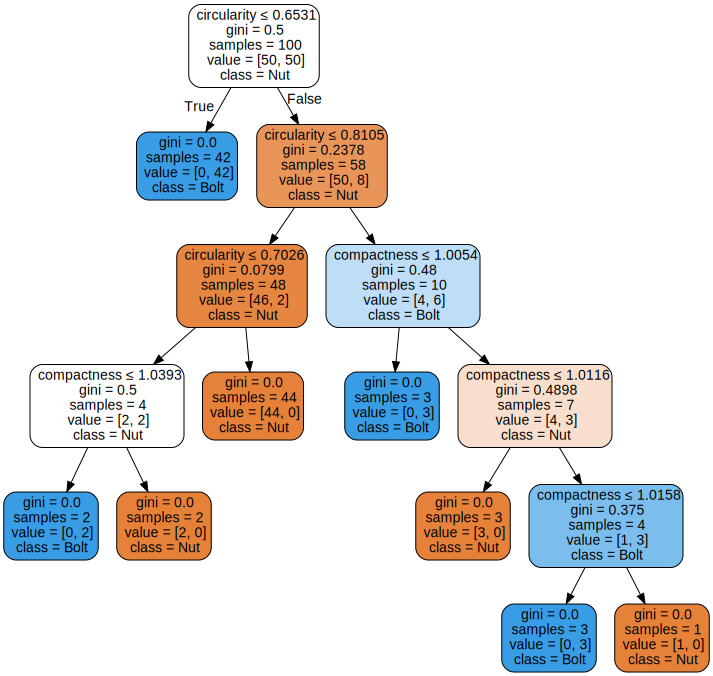

In [12]:
import graphviz 
dot_data = tree.export_graphviz(dec_tr_clf, out_file=None,
                                feature_names=['circularity', 'compactness'],
                                class_names=['Nut', 'Bolt'],
                                filled=True, rounded=True,
                                special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("Nuts and Bolts")
graph

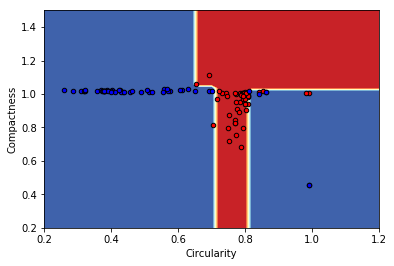

In [42]:
plot_step = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = dec_tr_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

plt.xlabel('Circularity')
plt.ylabel('Compactness')
target_names = ['Nut', 'Bolt']

# Plot the training points
for i, color in zip(range(2), 'rb'):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=target_names[i],
                cmap=plt.cm.RdYlBu, edgecolor='black', s=20)
plt.xlim([0.2, 1.2])
plt.ylim([0.2, 1.5])
plt.show()

## Logistic Regression

In [26]:
from sklearn import linear_model
log_reg_clf = linear_model.LogisticRegression()

# we create an instance of Neighbours Classifier and fit the data.
log_reg_clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
print('Logistic Regression Accuracy = ', test_model(log_reg_clf, test_X, test_y))

('Logistic Regression Accuracy = ', 87.2340425531915)


### Logistic Regression Visualization

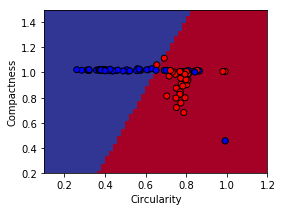

In [38]:
h = .02  # step size in the mesh
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = log_reg_clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.RdYlBu)

# Plot also the training points
y_clrs = ['r' if elem==0 else 'b' for elem in y]
plt.scatter(X[:, 0], X[:, 1], c=y_clrs, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Circularity')
plt.ylabel('Compactness')

plt.xlim([0.1, 1.2])
plt.ylim([0.2, 1.5])

plt.show()